In [257]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score


CARGA DE DATASETS

In [154]:
data_train = pd.read_csv('properties_colombia_train.csv')


In [155]:
data_train.describe()

,Unnamed: 0,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,197549.000000,148051.000000,148051.000000,27537.000000,40525.000000,156467.000000,6974.000000,9.802000e+03,1.974860e+05
mean,497437.843851,5.666001,-75.041045,3.291208,3.239062,2.639279,1352.132349,9.483356e+02,6.436051e+08
std,290023.578338,2.196804,1.104575,1.754795,1.985636,1.437174,7713.769352,3.730875e+04,1.944868e+09
min,0.000000,-32.787342,-119.698190,1.000000,0.000000,1.000000,10.000000,1.000000e+00,0.000000e+00
25%,234211.000000,4.582315,-75.645126,3.000000,3.000000,2.000000,72.000000,7.100000e+01,2.000000e+08
50%,507385.000000,4.908611,-75.476654,3.000000,3.000000,2.000000,120.000000,1.140000e+02,3.300000e+08
75%,770037.000000,6.248101,-74.094001,4.000000,4.000000,3.000000,281.000000,2.160000e+02,6.000000e+08
max,993551.000000,34.420334,-67.482570,40.000000,96.000000,20.000000,180000.000000,3.480000e+06,3.450000e+11


FORMATEO DE COLUMNAS:
<p>start_date ->date -> to_ordinal </p>
<p>end_date -> date -> to_ordinal </p>
<p>created_on -> date -> to_ordinal </p>


In [156]:
# Para verificar cantidad de datos con año 2020, 2021 y 9999 
#df=data_train.end_date.dropna().str.split('-', expand=True)
#df = df.astype({0:int , 1:int, 2:int})
#df.loc[:,0].value_counts()

In [157]:
# Asigna None a fechas que comienzan con 9999-
data_train['end_date'] = data_train['end_date'].map(lambda x: None if x.split('-')[0]=='9999' else x) 

In [158]:
# Conversion de tipo de dato a date de las tres columnas de con fechas
data_train['start_date'] = pd.to_datetime(data_train['start_date']) 
data_train['created_on'] = pd.to_datetime(data_train['created_on']) 
data_train['end_date'] = pd.to_datetime(data_train['end_date']) 


In [159]:
#evaluar consistencia de columnas con fechas
#data_train[['start_date', 'end_date', 'created_on']].describe(datetime_is_numeric=True)

In [160]:
import datetime as dt
data_train['start_date'] =  data_train['start_date'].map(dt.datetime.toordinal)
data_train['created_on'] =  data_train['created_on'].map(dt.datetime.toordinal)
data_train['end_date'] =  data_train['end_date'].map(dt.datetime.toordinal)


MANEJO DE INCONSISTENCIAS

Eliminación de datos con precio en dólares

In [161]:
ind_dolar=data_train[data_train.currency=='USD'].index.tolist()
data_train.drop(index=ind_dolar , inplace=True)

Eliminación de nulos basados en columnas 'currency', 'price'

In [162]:
data_train.dropna(subset=['price','currency'], inplace=True) # se eliminan 67 filas que no tienen price o currency

Valores de lat() y lon() fuera de rango

In [163]:
# Visualizar fuera de rango en lat y lon
#data_train[['lat' , 'lon','title', 'description', 'property_type', 'l2', 'l3', 'price']][(data_train.lat<-4.2) | (data_train.lat>13.4)] # visualizar lat fuera de rango
#data_train[['lon' , 'l2', 'l3']][(data_train.lon<-81.74) | (data_train.lon>-67)] # visualizar lon fuera de rango

In [164]:
# Eliminar lat fuera de rango
ind_out_of_range =data_train.index[(data_train.lat<-4.2) | (data_train.lat>13.4)].tolist() 
data_train.drop(index=ind_out_of_range, inplace=True)

In [165]:
# comprobación de lat y lon
#data_train[['lat','lon']].describe()

Identificacion y eliminación de columnas que no dan información:

In [166]:
# verificación de utilidad de columna created_on
#dif_fecha=data_train.start_date - data_train.created_on #calcula diferencia entre start_date y created_on
#dif_fecha.value_counts() # todas las diferencias son 0 luego son dos columnas exactamente iguales

In [167]:
# verificación de utilidad de columna geometry
#data_train[['lat','lon','geometry']].isnull().value_counts()# cuenta la cantidad de conbinaciones de nulos que hay entre lat, lon y geometry
#temp=data_train[['lat','lon','geometry']][data_train.lat.isnull()] #crea dataframe con lat==null
#temp.geometry.value_counts() # se verifica  que todas las filas con lat==null tambien geometry=='POINT EMPTY'

In [168]:

columnas_descartables = ['id','Unnamed: 0','created_on','l1', 'operation_type', 'ad_type', 'price_period','currency', 'geometry']
data_train.drop(columns=columnas_descartables, inplace=True) # eliminación de columnas que no agregan info

Eliminación de duplicados, se crean dos datasets:
- data_train_sf: se crea eliminando duplicados de data_train sin las columnas start_date y end_date
- data_train: se crea eliminando duplicados de data_train

In [169]:
# la eliminación de duplicados cuya diferencia son start_date o end_date depende de si se utilizan estos atributos
#data_train.drop(columns=['start_date','end_date']).duplicated().value_counts() # contar catidad de duplicados
data_train_sf= data_train.drop(columns=['start_date','end_date']).drop_duplicates() #se eliminan 74229 filas
data_train_sf.reset_index(inplace=True, drop=True)

In [170]:
#verificación de cantidad de duplicados según columnas incluidas
data_train.loc[:,['title','description','price', 'l2','l3','l4','l5','l6','property_type']].duplicated().value_counts()

False    122325
True      75147
dtype: int64

In [171]:
data_train.drop_duplicates(inplace=True) # elimina duplicados de data_train teniendo en cuenta todas las columnas
data_train.reset_index(inplace=True, drop=True)

In [172]:
data_train.columns

Index(['start_date', 'end_date', 'lat', 'lon', 'l2', 'l3', 'l4', 'l5', 'l6',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'title', 'description', 'property_type'],
      dtype='object')

PREPROCESAMIENTO

- Codificación de variables categoricas nominales con get_dummies()

In [179]:
dummies = pd.get_dummies(data_train_sf, columns=['l2','l3','l4','property_type']) #obtener dummies de l ubicaciones y property_type
dummies.drop(columns=['lat', 'lon', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'title', 'description'] , inplace=True)

- Reducción de dimensionalidad. PCA 

In [181]:
from sklearn.decomposition import PCA #reducen de aprox 400 dummies a 20
pca = PCA(n_components=20)
dummies_reduc=pca.fit_transform(dummies)

In [183]:
dummies_reduc = pd.DataFrame(dummies_reduc) 

In [184]:
dummies_reduc= pd.concat([data_train_sf[['lat','lon']],dummies_reduc], axis=1) # concateno 20 dummies con lat y lon

- imputación de valores faltantes pendiente!!!!!!!!!

Imputacion de lat y loc

In [117]:
#corr_dummies = dummies.corr()

In [118]:
#lt.figure(figsize=(26,20))
#sns.heatmap(corr_dummies, square=True, annot=False, cmap='coolwarm')

In [187]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3, add_indicator=True)
latlon_filled_array = imputer.fit_transform(dummies_reduc)

c:\Users\jcgut\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jcgut\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [191]:
latlon_filled_array= np.delete(latlon_filled_array,list(range(2,23)),axis=1) #elimino dummies del array

In [193]:

latlon_filledcolumns=['lat','lon','imputed'] #convierto array de lat y lon filled a dataframe
latlon_filled = pd.DataFrame(latlon_filled_array, columns=latlon_filledcolumns)
latlon_filled.head()

,lat,lon,imputed
0,6.203000,-75.572000,0.0
1,4.722748,-74.073115,0.0
2,4.709000,-74.030000,0.0
3,7.114019,-73.114067,1.0
4,6.233673,-75.576800,1.0


In [ ]:
plt.figure(figsize=(16,16))
sns.scatterplot(data=latlon_filled, x='lon', y='lat', hue='imputed')

In [195]:
data_train_sf.columns

Index(['lat', 'lon', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'surface_covered', 'price', 'title',
       'description', 'property_type'],
      dtype='object')

In [196]:
#asigno columnas de lat lon imputadas a el dataframe principal
data_train_sf['lat']=latlon_filled['lat']
data_train_sf['lon']=latlon_filled['lon']
data_train_sf.insert(2,"loc_mis_ind", latlon_filled['imputed'])

Imputacion de bathrooms, bedrooms, rooms

In [208]:
#obtengo dummies de property_type para rellenar rooms, bedrooms, bathrooms, surface_total, surface_covered
dummies = pd.get_dummies(data_train_sf, columns=['property_type'])
dummies.drop(columns=['lat', 'lon','loc_mis_ind','l2','l3','l4', 'l5', 'l6', 'price', 'title', 'description'] , inplace=True)

In [216]:
dummies.columns

Index(['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'property_type_Apartamento', 'property_type_Casa',
       'property_type_Finca', 'property_type_Local comercial',
       'property_type_Lote', 'property_type_Oficina', 'property_type_Otro',
       'property_type_Parqueadero'],
      dtype='object')

In [210]:
imputer_rooms = KNNImputer(n_neighbors=3, add_indicator=True)
rooms_filled_array = imputer_rooms.fit_transform(dummies)

In [217]:
# elimino dummies de array que resulta de la imputación
# rooms_filled_array = np.delete(rooms_filled_array,list(range(5,13)),axis=1)

In [220]:
# corvierto a dataframe al arraycorregido resultado de la imputación
rooms_filledcolumns=[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered','ro_mis_ind','br_mis_ind','ba_mis_ind','st_mis_ind','sc_mis_ind']]
rooms_filled = pd.DataFrame(rooms_filled_array, columns=rooms_filledcolumns)
rooms_filled.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,ro_mis_ind,br_mis_ind,ba_mis_ind,st_mis_ind,sc_mis_ind
0,4.0,4.000000,4.0,163.333333,198.333333,1.0,0.0,0.0,1.0,1.0
1,3.0,3.000000,2.0,86.666667,60.000000,1.0,0.0,0.0,1.0,1.0
2,4.0,4.000000,2.0,953.333333,114.666667,1.0,1.0,0.0,1.0,1.0
3,4.0,4.000000,1.0,422.666667,654.333333,1.0,1.0,0.0,1.0,1.0
4,3.0,3.666667,2.0,85.333333,86.000000,1.0,1.0,0.0,1.0,1.0


In [222]:
# reemplazo columnas con valores columnas llenas
data_train_sf['rooms']=rooms_filled['rooms']
data_train_sf['bedrooms']=rooms_filled['bedrooms']
data_train_sf['bathrooms']=rooms_filled['bathrooms']
data_train_sf['surface_total']=rooms_filled['surface_total']
data_train_sf['surface_covered']=rooms_filled['surface_covered']

data_train_sf = pd.concat([data_train_sf , rooms_filled[['ro_mis_ind', 'br_mis_ind', 'ba_mis_ind', 'st_mis_ind', 'sc_mis_ind']]], axis=1)

In [267]:
#exporto data_train_sf a csv
data_train_sf.to_csv('data_train_sf.csv', index=False)

In [226]:
data_train_sf.describe()

,lat,lon,loc_mis_ind,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,"(ro_mis_ind,)","(br_mis_ind,)","(ba_mis_ind,)","(st_mis_ind,)","(sc_mis_ind,)"
count,123243.000000,123243.000000,123243.000000,123243.000000,123243.000000,123243.000000,123243.000000,1.232430e+05,1.232430e+05,123243.000000,123243.000000,123243.000000,123243.000000,123243.000000
mean,5.795453,-75.035981,0.121167,3.454062,3.373547,2.679308,942.113835,1.855787e+03,6.777911e+08,0.781156,0.676801,0.267942,0.943794,0.921058
std,2.283291,1.067700,0.326323,1.162927,1.327923,1.333930,4732.687902,1.798167e+04,2.233063e+09,0.413464,0.467700,0.442889,0.230320,0.269649
min,0.823972,-81.728390,0.000000,1.000000,0.000000,1.000000,10.000000,1.000000e+00,9.000000e+05,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.603630,-75.625999,0.000000,3.000000,3.000000,2.000000,85.333333,8.600000e+01,1.994182e+08,1.000000,0.000000,0.000000,1.000000,1.000000
50%,4.921805,-75.445566,0.000000,3.000000,3.666667,2.000000,118.666667,1.243333e+02,3.400000e+08,1.000000,1.000000,0.000000,1.000000,1.000000
75%,6.259131,-74.095398,0.000000,4.000000,4.000000,3.000000,351.000000,2.100000e+02,6.400000e+08,1.000000,1.000000,1.000000,1.000000,1.000000
max,13.351917,-67.482570,1.000000,40.000000,96.000000,20.000000,180000.000000,3.480000e+06,3.450000e+11,1.000000,1.000000,1.000000,1.000000,1.000000


In [227]:
data_train.describe()

,start_date,end_date,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,193704.000000,193704.000000,145050.000000,145050.000000,27453.000000,40410.000000,153270.000000,6942.000000,9.755000e+03,1.937040e+05
mean,737708.060500,692227.332698,5.670810,-75.040305,3.290169,3.239198,2.637822,1329.734515,9.467107e+02,6.439675e+08
std,46.044437,177512.921215,2.195904,1.097529,1.753813,1.985420,1.436906,7649.530162,3.739528e+04,1.956065e+09
min,737632.000000,1.000000,0.823972,-81.728390,1.000000,0.000000,1.000000,10.000000,1.000000e+00,9.000000e+05
25%,737666.000000,737677.000000,4.583527,-75.645297,3.000000,3.000000,2.000000,72.000000,7.100000e+01,2.000000e+08
50%,737710.000000,737734.000000,4.911880,-75.478000,3.000000,3.000000,2.000000,120.000000,1.140000e+02,3.300000e+08
75%,737750.000000,737778.000000,6.248000,-74.093970,4.000000,4.000000,3.000000,280.000000,2.160000e+02,6.000000e+08
max,737790.000000,738081.000000,13.351917,-67.482570,40.000000,96.000000,20.000000,180000.000000,3.480000e+06,3.450000e+11


- StandardScaler

grafico de localizacion

<AxesSubplot:xlabel='lon', ylabel='lat'>

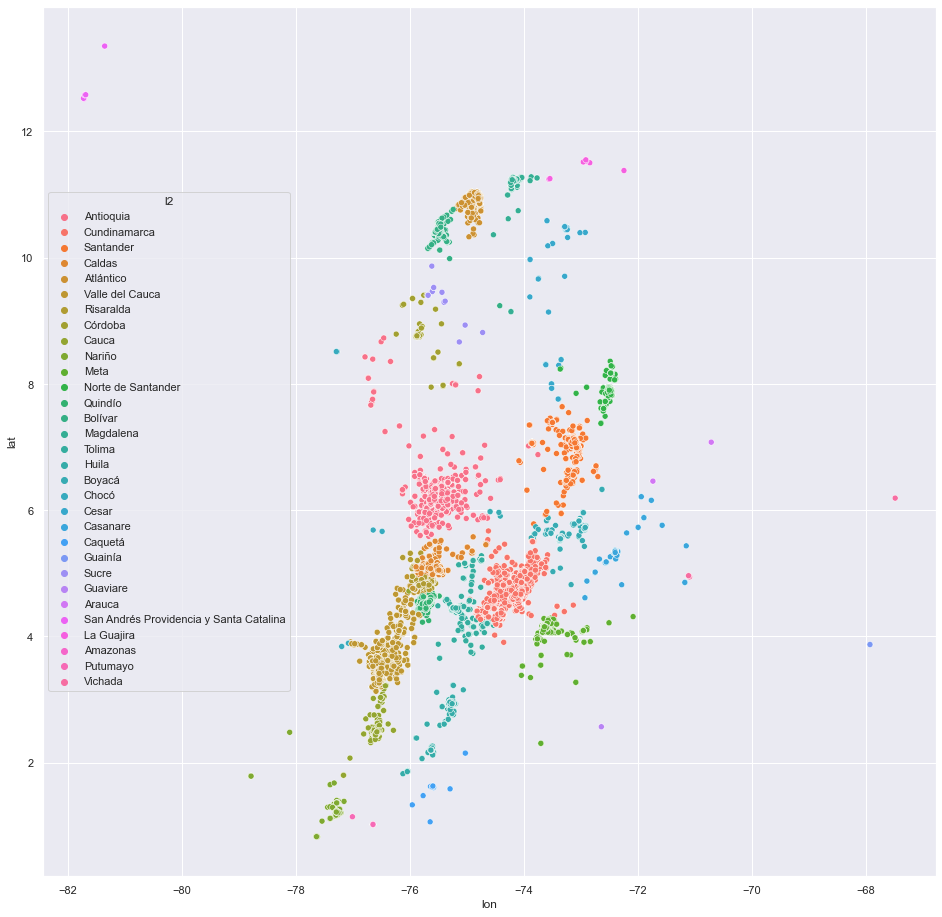

In [258]:
plt.figure(figsize=(16,16))
sns.scatterplot(data=data_train, x='lon', y='lat', hue='l2')

EDA (selección de features)

- creación de target

(0.0, 2000000000.0)

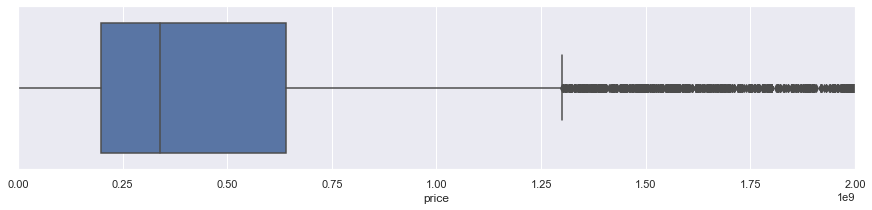

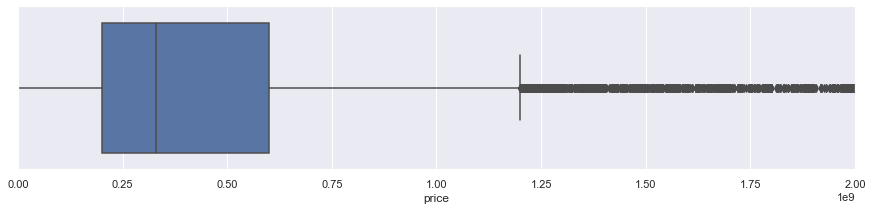

In [229]:
plt.figure(figsize=(15,3))
sns.boxplot(x=data_train_sf['price'])
plt.xlim(0,2000000000)
plt.figure(figsize=(15,3))
sns.boxplot(x=data_train['price'])
plt.xlim(0,2000000000)

In [235]:
price_mean = data_train.price.mean()
data_train['target'] = data_train.price.map(lambda x: 1 if x>= price_mean else 0)
data_train_sf['target'] = data_train_sf.price.map(lambda x: 1 if x>= price_mean else 0)

- verificar balanceo

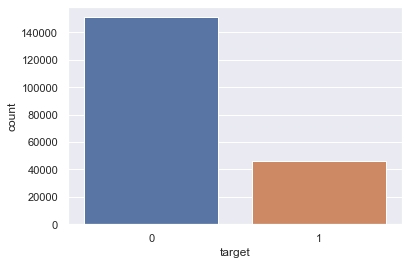

In [226]:
sns.countplot(x='target', data=data_train )
plt.show()

- ver correlación: corr() , pairplot()

In [227]:
# se crea matriz de correlación entre variables numericas
corr = data_train[['start_date', 'end_date', 'lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price']].corr(method='pearson')

<AxesSubplot:>

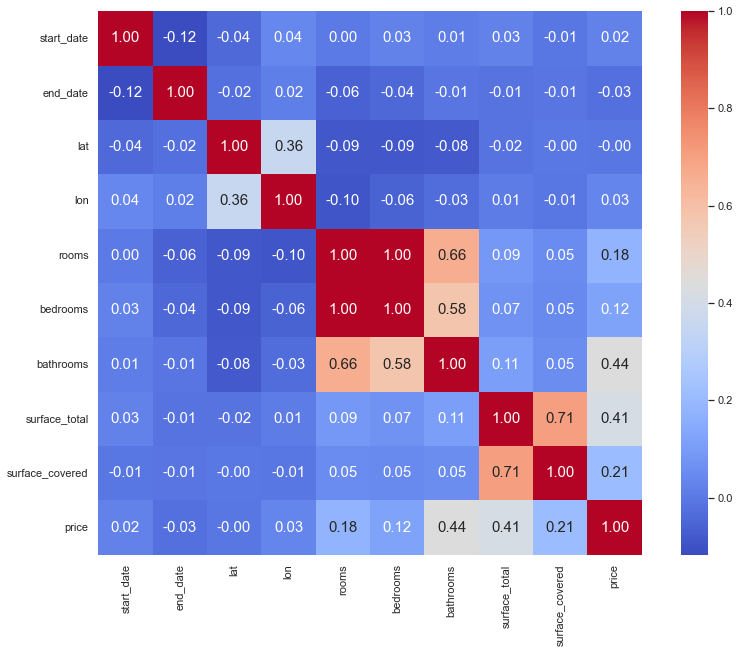

In [228]:

plt.figure(figsize=(14,10))
cols_heatmap=['start_date', 'end_date', 'lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']
sns.heatmap(corr, square=True, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size':15}, xticklabels=cols_heatmap, yticklabels=cols_heatmap)

In [231]:
corr_sf_filled = data_train_sf[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price']].corr(method='pearson')

<AxesSubplot:>

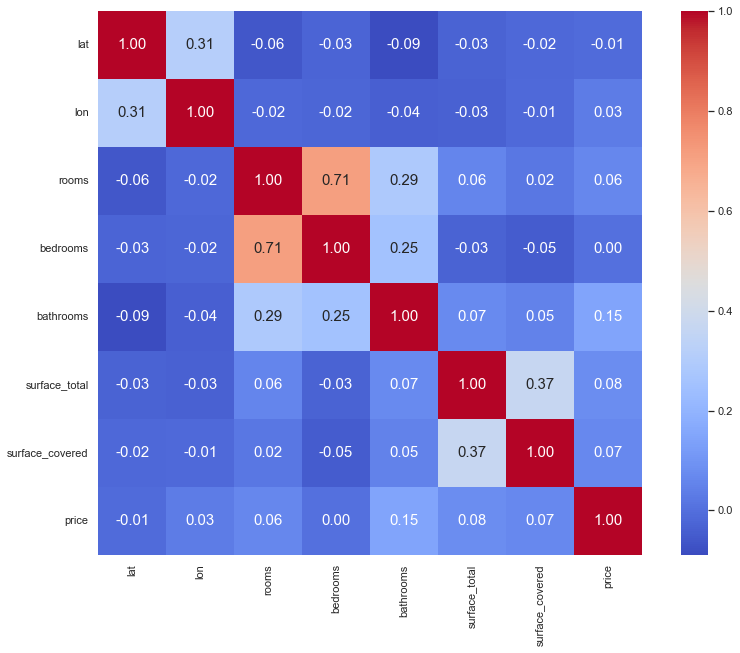

In [232]:
plt.figure(figsize=(14,10))
cols_heatmap=['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']
sns.heatmap(corr_sf_filled, square=True, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size':15}, xticklabels=cols_heatmap, yticklabels=cols_heatmap)

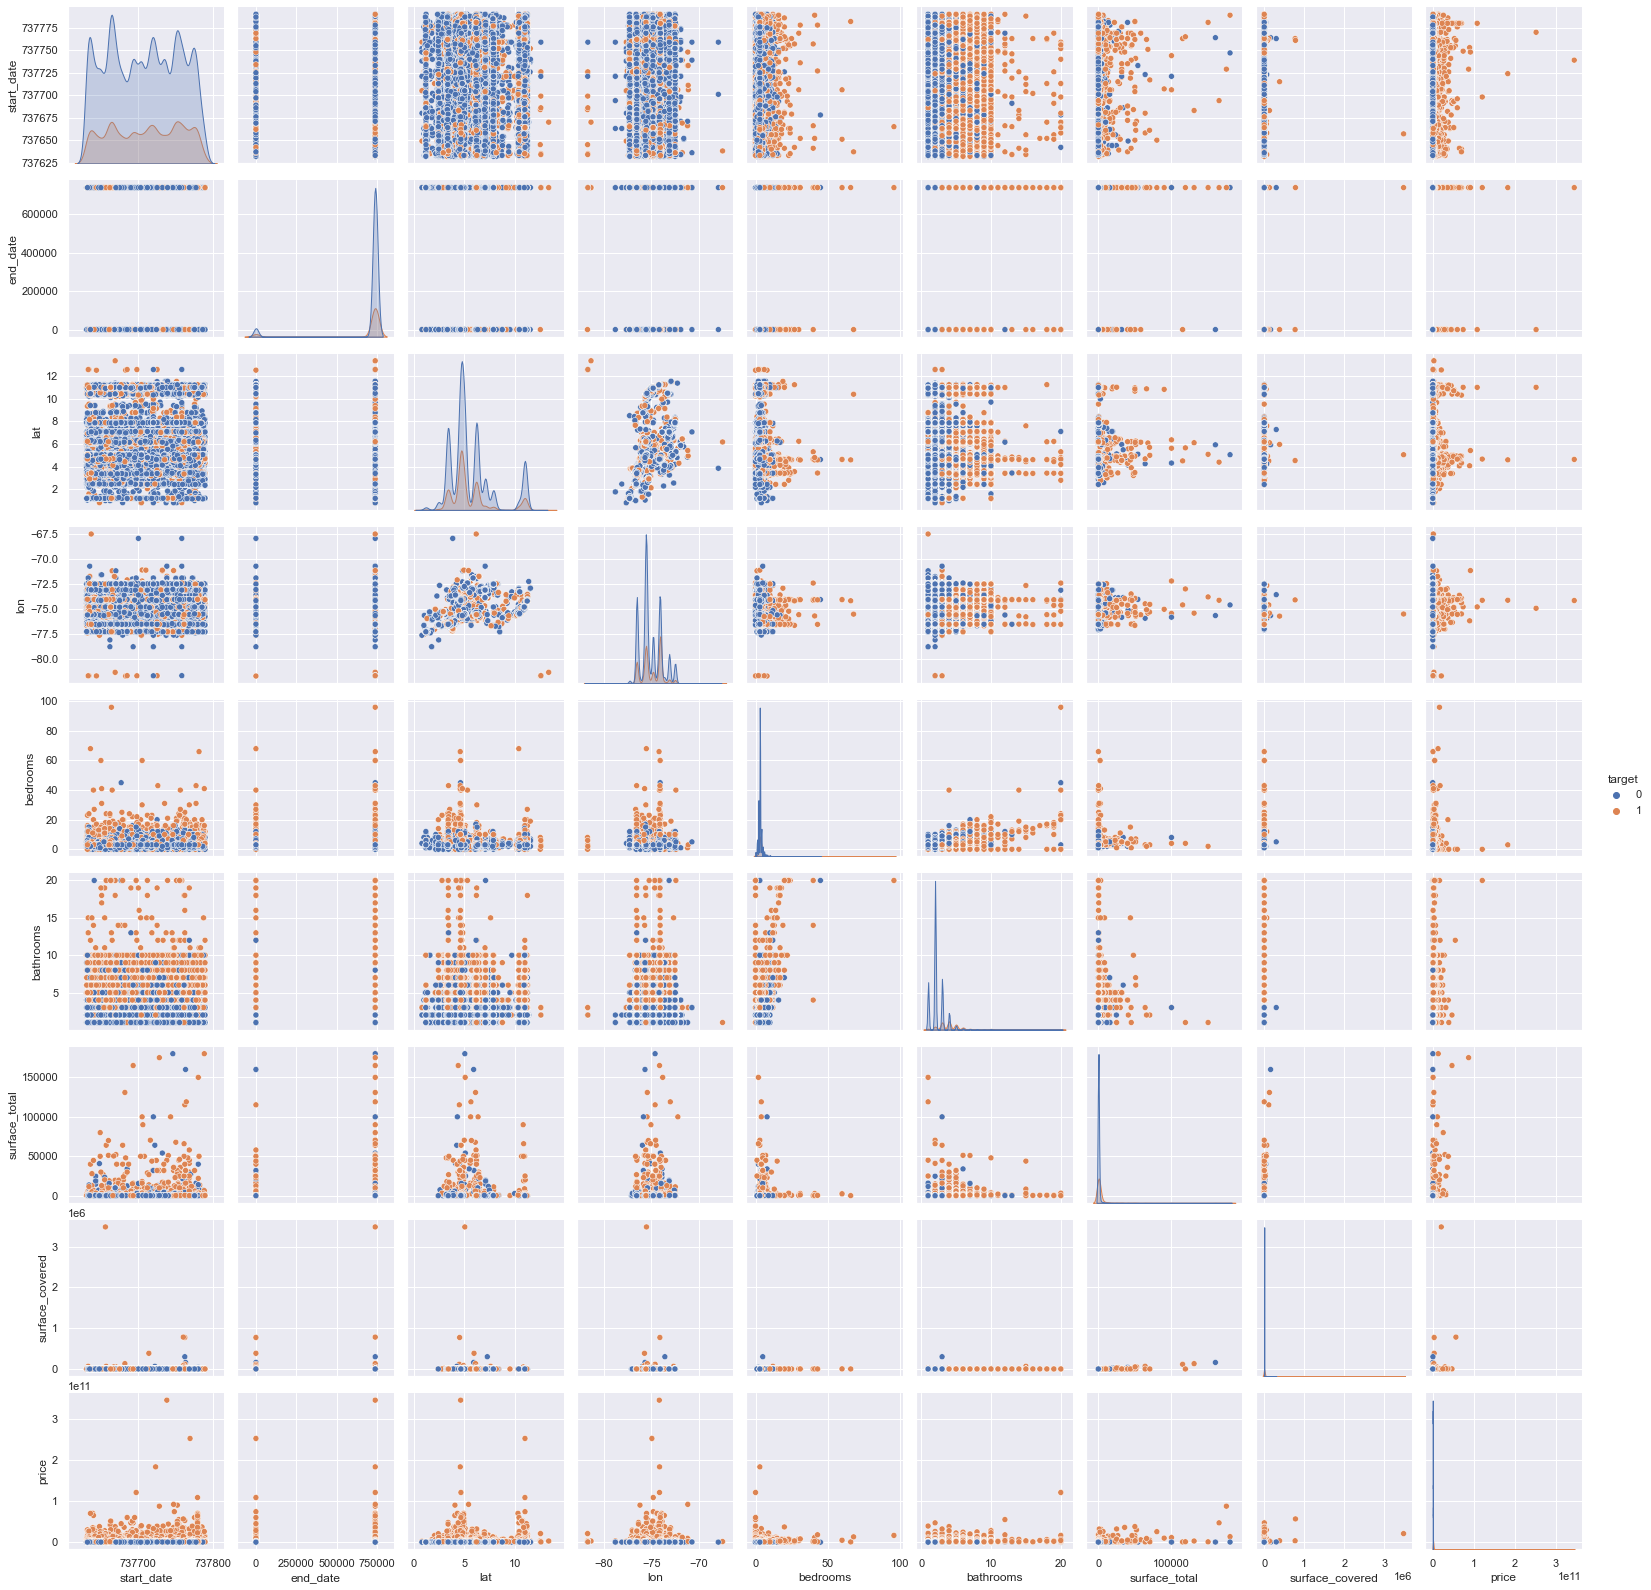

In [229]:
sns.pairplot(data=data_train[['start_date', 'end_date', 'lat', 'lon', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered','price' ,'target']], hue='target')

hasta aquí se seleccionan los features surface_covered, bathrooms y rooms

- seleccion de features con sklearn.feature_selection.SelectKBest

In [233]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif

In [244]:
selector_price= SelectKBest(mutual_info_regression, k=6)
selector_target= SelectKBest(mutual_info_classif, k=6)

In [245]:
X= data_train_sf[[ 'lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']].values
y_price = data_train_sf[['price']].values
y_target = data_train_sf[['target']].values

In [246]:
selector_price.fit(X,y_price)
selector_target.fit(X,y_target)

c:\Users\jcgut\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jcgut\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelectKBest(k=6,
            score_func=<function mutual_info_classif at 0x000001F416C409D0>)

In [248]:
print( selector_price.scores_)
print( selector_target.scores_)


[0.57585871 0.53498464 0.09770252 0.13970448 0.28832843 0.42126426
 0.4153278 ]
[0.12632182 0.11644241 0.03385466 0.04744379 0.10786201 0.16147299
 0.15772281]


APLICACIÓN DE MODELOS

Entrenamiento (pipelines)

`HistGradientBoostingClassifier()`

In [254]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf_HGBC=HistGradientBoostingClassifier(scoring='accuracy').fit(X,y_target)
clf_HGBC.score(X, y_target)

c:\Users\jcgut\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8658098228702644

`RandomForestClassifier()`

In [256]:
from sklearn.ensemble import RandomForestClassifier
clf_RFC = RandomForestClassifier(n_estimators=100, max_features='sqrt', n_jobs=-1, oob_score = True, random_state = 42)
clf_RFC.fit(X, y_target)

C:\Users\jcgut\AppData\Local\Temp\ipykernel_13348\5926260.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_RFC.fit(X, y_target)


RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [258]:
y_train_pred_RF = clf_RFC.predict(X)

print('recall:', recall_score(y_target, y_train_pred_RF))
print('accuracy', accuracy_score(y_target, y_train_pred_RF))

recall: 0.935386020418148
accuracy 0.9747003886630478


`BaggingClassifier()`   `AdaBoostClassifier()` `LogisticRegression()` `svm.SVC-89`  `XGBClassifier()` `` ``

Preparación de dataset de testeo

In [261]:
data_test = pd.read_csv('properties_colombia_test.csv')

In [259]:
"""# Asigna None a fechas que comienzan con 9999-
data_test['end_date'] = data_test['end_date'].map(lambda x: None if x.split('-')[0]=='9999' else x) 
# Conversion de tipo de dato a date de las tres columnas de con fechas
data_test['start_date'] = pd.to_datetime(data_test['start_date']) 
data_test['created_on'] = pd.to_datetime(data_test['created_on']) 
data_test['end_date'] = pd.to_datetime(data_test['end_date']) 
# conversion de date a ordinal
#import datetime as dt
data_test['start_date'] =  data_test['start_date'].map(dt.datetime.toordinal)
data_test['created_on'] =  data_test['created_on'].map(dt.datetime.toordinal)
data_test['end_date'] =  data_test['end_date'].map(dt.datetime.toordinal)"""

In [262]:
columnas_descartables = ['id','Unnamed: 0','start_date' ,'end_date','created_on','l1', 'operation_type', 'ad_type', 'price_period','currency', 'geometry']
data_test.drop(columns=columnas_descartables, inplace=True) # eliminación de columnas que no agregan info

In [264]:
dummies = pd.get_dummies(data_test, columns=['l2','l3','l4','property_type']) #obtener dummies de l ubicaciones y property_type
dummies.drop(columns=['lat', 'lon','l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'title', 'description'] , inplace=True)

In [268]:
from sklearn.decomposition import PCA #reducen de aprox 400 dummies a 20
pca = PCA(n_components=20)
dummies_reduc=pca.fit_transform(dummies)
dummies_reduc = pd.DataFrame(dummies_reduc)
dummies_reduc= pd.concat([data_test[['lat','lon']],dummies_reduc], axis=1) 

In [270]:
from sklearn.impute import KNNImputer # imputacion de lat y lon con los 20 dummies
imputer = KNNImputer(n_neighbors=3, add_indicator=True)
latlon_filled_array = imputer.fit_transform(dummies_reduc)

c:\Users\jcgut\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jcgut\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [271]:
latlon_filled_array= np.delete(latlon_filled_array,list(range(2,23)),axis=1) #elimino dummies del array
latlon_filledcolumns=['lat','lon','imputed'] #convierto array de lat y lon filled a dataframe
latlon_filled = pd.DataFrame(latlon_filled_array, columns=latlon_filledcolumns)

In [277]:
#asigno columnas de lat lon imputadas a el dataframe principal
data_test['lat']=latlon_filled['lat']
data_test['lon']=latlon_filled['lon']
data_test.insert(2,"loc_mis_ind", latlon_filled['imputed'])

In [281]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65850 entries, 0 to 65849
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   rooms                          9110 non-null   float64
 1   bedrooms                       13403 non-null  float64
 2   bathrooms                      52054 non-null  float64
 3   surface_total                  2314 non-null   float64
 4   surface_covered                3305 non-null   float64
 5   property_type_Apartamento      65850 non-null  uint8  
 6   property_type_Casa             65850 non-null  uint8  
 7   property_type_Finca            65850 non-null  uint8  
 8   property_type_Local comercial  65850 non-null  uint8  
 9   property_type_Lote             65850 non-null  uint8  
 10  property_type_Oficina          65850 non-null  uint8  
 11  property_type_Otro             65850 non-null  uint8  
 12  property_type_Parqueadero      65850 non-null 

In [280]:
#obtengo dummies de property_type para rellenar rooms, bedrooms, bathrooms, surface_total, surface_covered
dummies = pd.get_dummies(data_test, columns=['property_type'])
dummies.drop(columns=['lat', 'lon','loc_mis_ind','l2','l3','l4', 'l5', 'l6', 'title', 'description'] , inplace=True)

In [282]:
# imputar rooms, bedrooms, bathrooms, surface_total, surface_covered
imputer_rooms = KNNImputer(n_neighbors=3, add_indicator=True)
rooms_filled_array = imputer_rooms.fit_transform(dummies)

In [284]:
# elimino dummies del array que resulta de la imputación
rooms_filled_array = np.delete(rooms_filled_array,list(range(5,13)),axis=1)
# convierto a dataframe al arraycorregido resultado de la imputación
rooms_filledcolumns=[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered','ro_mis_ind','br_mis_ind','ba_mis_ind','st_mis_ind','sc_mis_ind']]
rooms_filled = pd.DataFrame(rooms_filled_array, columns=rooms_filledcolumns)

In [285]:
# reemplazo columnas con valores de columnas llenas
data_test['rooms']=rooms_filled['rooms']
data_test['bedrooms']=rooms_filled['bedrooms']
data_test['bathrooms']=rooms_filled['bathrooms']
data_test['surface_total']=rooms_filled['surface_total']
data_test['surface_covered']=rooms_filled['surface_covered']

In [288]:
X_test= data_test[[ 'lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']].values

Evaluación 

In [292]:
y_target_pred_HGBC = clf_HGBC.predict(X)
print('accuracy sobre el conjunto de Entrenamiento:', accuracy_score(y_target , y_target_pred_HGBC))
print('recall sobre el conjunto de Evaluación:', recall_score(y_target , y_target_pred_HGBC))

accuracy sobre el conjunto de Entrenamiento: 0.8658098228702644
recall sobre el conjunto de Evaluación: 0.6520760624938844


In [293]:
y_target_pred_RF= clf_RFC.predict(X)
print('accuracy sobre el conjunto de Entrenamiento:', accuracy_score(y_target , y_target_pred_RF))
print('recall sobre el conjunto de Evaluación:', recall_score(y_target , y_target_pred_RF))

accuracy sobre el conjunto de Entrenamiento: 0.9747003886630478
recall sobre el conjunto de Evaluación: 0.935386020418148


Predicción en dataset test y exportación a csv

In [238]:
y_test_pred= clf_HGBC.predict(X_test)

In [ ]:
y_test_pred_RF = clf_RFC.predict(X)

In [239]:
y_test_pred=pd.DataFrame(y_test_pred, columns=['pred'] )

In [241]:
y_test_pred.to_csv('CesarG2022.csv', index=False)